Oday Ziq

**Step 1: Load the Data and Preprocess It**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

!rm -rf ./ENCS5141Datasets
!git clone https://github.com/mkjubran/ENCS5141Datasets.git

df = pd.read_csv("/content/ENCS5141Datasets/BankNotesDataset.csv")
print(df.head())
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.info())
print(df.isnull().sum())
print(df[df.isnull().any(axis=1)])

currency_encoder = LabelEncoder()
df['Currency'] = currency_encoder.fit_transform(df['Currency'])

denominations, orientations = zip(*df['Denomination'].apply(lambda x: x.split('_')))
df['Denomination'] = denominations
df['Orientation'] = orientations

df['Denomination'] = pd.to_numeric(df['Denomination'], errors='coerce')
df['Orientation'] = pd.to_numeric(df['Orientation'], errors='coerce')
print(df['Currency'].unique())
print(df['Denomination'].unique())
print(df['Orientation'].unique())
print(df.info())

X = df.drop(['Currency', 'Denomination', 'Orientation'], axis=1)
y = df[['Currency', 'Denomination', 'Orientation']]

X_train, X_test, y_train, y_test = train_test_split(X, y['Currency'], test_size=0.2, random_state=42)

X_features = df.iloc[:, :-3]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

y_currency = df['Currency']
y_denomination = pd.to_numeric(df['Denomination'], errors='coerce')
y_orientation = pd.to_numeric(df['Orientation'], errors='coerce')


Cloning into 'ENCS5141Datasets'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 60 (delta 14), reused 50 (delta 7), pack-reused 0
Receiving objects: 100% (60/60), 22.99 MiB | 22.88 MiB/s, done.
Resolving deltas: 100% (14/14), done.
   Unnamed: 0       v_0       v_1       v_2       v_3       v_4       v_5  \
0           0  0.000000  0.802783  4.799193  3.520272  3.906448  2.964886   
1           1  1.282011  0.169436  4.367540  4.476254  5.645983  2.173897   
2           2  1.956406  0.000000  5.244660  3.611655  5.085964  3.766434   
3           3  0.382722  3.727718  4.409414  3.093557  6.277169  0.000000   
4           4  0.619588  0.071276  3.780865  3.637381  4.144943  3.829269   

        v_6       v_7       v_8  ...     v_248     v_249     v_250     v_251  \
0  2.276473  0.472117  0.000000  ...  0.319955  5.005167  5.144637  0.000000   
1  0.638572  0.000000  0.149849  ...  0.67

**Step 2: Apply PCA for Dimensionality Reduction**


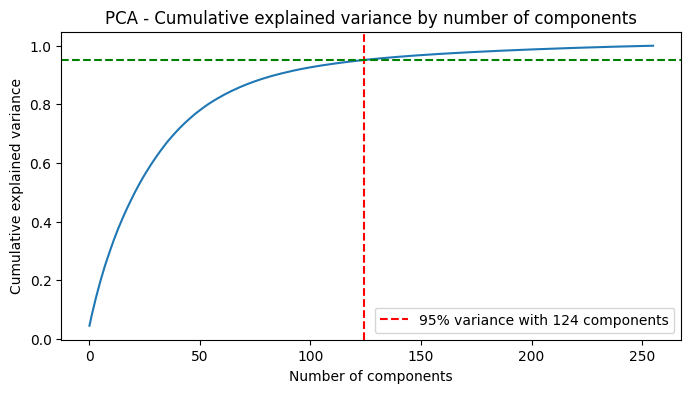

In [21]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_full = PCA()
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

pca_optimal = PCA(n_components=n_components_95)
X_pca = pca_optimal.fit_transform(X_scaled)

plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA - Cumulative explained variance by number of components')
plt.axvline(x=n_components_95, color='r', linestyle='--', label=f'95% variance with {n_components_95} components')
plt.axhline(y=0.95, color='g', linestyle='--')
plt.legend()
plt.show()


**Step 3: Train SVM and MLP Classifiers Without PCA**

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best parameters for SVC: {'C': 1, 'kernel': 'rbf'}
Train set Accuracy for SVC: 0.98
Test set Accuracy for SVC: 0.97
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Best parameters for MLPClassifier: {'alpha': 0.01, 'batch_size': 100, 'early_stopping': False, 'learning_rate': 'constant', 'solver': 'adam'}
Train set Accuracy for MLPClassifier: 1.00
Test set Accuracy for MLPClassifier: 0.97


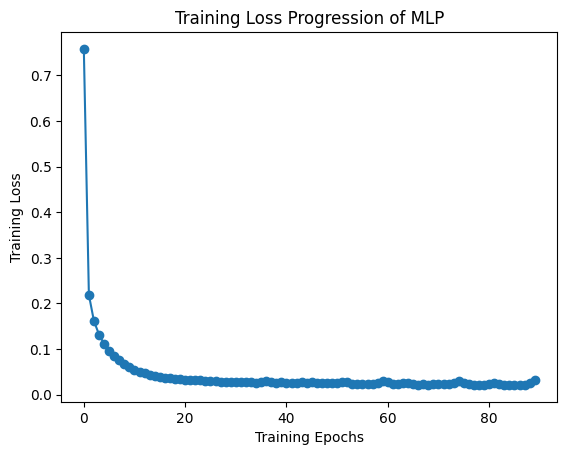

In [22]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

def train_and_evaluate_model(model, parameters, X_train, y_train, X_test, y_test, scale_data=False):
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    clf = GridSearchCV(model, parameters, cv=2, n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train)

    print(f"Best parameters for {model.__class__.__name__}: {clf.best_params_}")

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    print(f"Train set Accuracy for {model.__class__.__name__}: {accuracy_score(y_train, y_pred_train):.2f}")
    print(f"Test set Accuracy for {model.__class__.__name__}: {accuracy_score(y_test, y_pred_test):.2f}")

    return clf

svc_parameters = {
    "kernel": ['rbf', 'poly'],
    "C": [0.1, 1]
}

svc_model = svm.SVC()
svc_clf = train_and_evaluate_model(svc_model, svc_parameters, X_train, y_train, X_test, y_test)

mlp_parameters = {
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.01],
    'batch_size': [100, 200],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': [False]
}


mlp_model = MLPClassifier(random_state=42)
mlp_clf = train_and_evaluate_model(mlp_model, mlp_parameters, X_train, y_train, X_test, y_test, scale_data=True)

best_mlp = mlp_clf.best_estimator_
plt.plot(best_mlp.loss_curve_, marker='o')
plt.title('Training Loss Progression of MLP')
plt.xlabel('Training Epochs')
plt.ylabel('Training Loss')
plt.show()


In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(activation='tanh', hidden_layer_sizes=(90, 60), learning_rate_init=0.001, max_iter=1000, random_state=33)
mlp.fit(X_train, y_train)

train_pred = mlp.predict(X_train)
y_pred = mlp.predict(X_test)

train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Train set Accuracy score: {train_accuracy:.2f}")
print(f"Test set Accuracy score: {test_accuracy:.2f}")


Train set Accuracy score: 1.00
Test set Accuracy score: 0.96


**Step 4: Train SVM and MLP Classifiers With PCA**

In [24]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

def perform_pca(X, n_components=50):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca)

def train_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    return train_predictions, test_predictions

def print_accuracy(y_train, train_predictions, y_test, test_predictions, model_name):
    """ Print the accuracy of the model for both the training and test datasets. """
    print(f"Train set accuracy for {model_name}: {accuracy_score(y_train, train_predictions):.2f}")
    print(f"Test set accuracy for {model_name}: {accuracy_score(y_test, test_predictions):.2f}")

df_PCA = perform_pca(X)

X_train, X_test, y_train, y_test = train_test_split(df_PCA, y_currency, test_size=0.1, random_state=30)

svm_classifier = SVC(kernel='rbf', C=1)
train_preds_svm, test_preds_svm = train_model(svm_classifier, X_train, y_train, X_test)
print_accuracy(y_train, train_preds_svm, y_test, test_preds_svm, "SVM")

mlp_classifier = MLPClassifier(activation='tanh', hidden_layer_sizes=(90, 60), learning_rate_init=0.001, max_iter=1000, random_state=33)
train_preds_mlp, test_preds_mlp = train_model(mlp_classifier, X_train, y_train, X_test)
print_accuracy(y_train, train_preds_mlp, y_test, test_preds_mlp, "MLP")


Train set accuracy for SVM: 0.97
Test set accuracy for SVM: 0.96
Train set accuracy for MLP: 1.00
Test set accuracy for MLP: 0.94


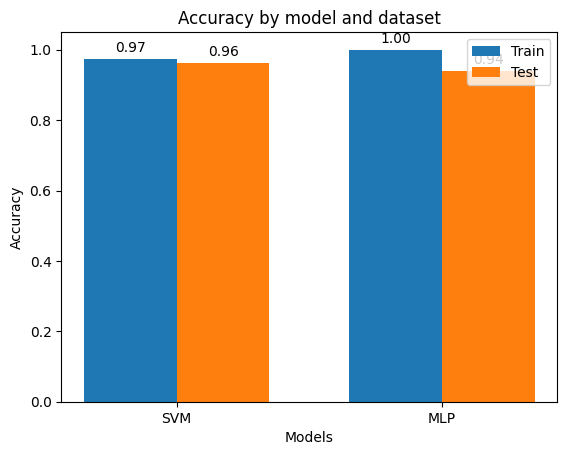

In [25]:
import matplotlib.pyplot as plt

train_accuracy_svm = accuracy_score(y_train, train_preds_svm)
test_accuracy_svm = accuracy_score(y_test, test_preds_svm)
train_accuracy_mlp = accuracy_score(y_train, train_preds_mlp)
test_accuracy_mlp = accuracy_score(y_test, test_preds_mlp)

models = ['SVM', 'MLP']
train_accuracies = [train_accuracy_svm, train_accuracy_mlp]
test_accuracies = [test_accuracy_svm, test_accuracy_mlp]

x = range(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x, train_accuracies, width, label='Train')
rects2 = ax.bar([p + width for p in x], test_accuracies, width, label='Test')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by model and dataset')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()


**Step 5: Hyperparameter Tuning with Grid Search**

In [26]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(clf, param_grid, X_train, y_train):

    grid_search = GridSearchCV(clf, param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {clf.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_, grid_search.best_params_

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

mlp_param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [0.01, 0.001]
}

best_svm, best_svm_params = hyperparameter_tuning(svm.SVC(), svm_param_grid, X_train, y_train)
best_mlp, best_mlp_params = hyperparameter_tuning(MLPClassifier(random_state=42), mlp_param_grid, X_train, y_train)

train_preds_svm = best_svm.predict(X_train)
test_preds_svm = best_svm.predict(X_test)
train_preds_mlp = best_mlp.predict(X_train)
test_preds_mlp = best_mlp.predict(X_test)

print_accuracy(y_train, train_preds_svm, y_test, test_preds_svm, "Best SVM")
print_accuracy(y_train, train_preds_mlp, y_test, test_preds_mlp, "Best MLP")


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Best parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best parameters for MLPClassifier: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
Train set accuracy for Best SVM: 0.99
Test set accuracy for Best SVM: 0.97
Train set accuracy for Best MLP: 1.00
Test set accuracy for Best MLP: 0.96


**class orientation**

Different classes for the combined feature: ['0_10' '0_100' '0_20' '0_5' '0_50' '10_10' '10_100' '10_1000' '10_20'
 '10_200' '10_5' '10_50' '10_500' '11_10' '11_100' '11_20' '11_5' '11_50'
 '12_100' '12_1000' '12_20' '12_200' '12_50' '12_500' '13_10' '13_100'
 '13_1000' '13_20' '13_5' '13_50' '13_500' '13_5000' '14_10' '14_100'
 '14_2' '14_5' '14_50' '15_10' '15_100' '15_20' '15_200' '15_5' '15_50'
 '16_1' '16_10' '16_100' '16_2' '16_20' '16_5' '16_50' '1_10' '1_100'
 '1_2' '1_20' '1_200' '1_5' '1_50' '2_10' '2_100' '2_20' '2_5' '2_50'
 '3_10' '3_100' '3_20' '3_200' '3_5' '3_50' '4_10' '4_20' '4_5' '4_50'
 '5_1000' '5_100000' '5_2000' '5_20000' '5_5000' '5_50000' '6_1' '6_10'
 '6_100' '6_1000' '6_20' '6_200' '6_2000' '6_5' '6_50' '6_500' '7_1000'
 '7_10000' '7_2000' '7_5000' '8_100' '8_1000' '8_20' '8_200' '8_50'
 '8_500' '9_1' '9_10' '9_100' '9_20' '9_5' '9_50']
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Train set Accuracy score: 1.00
SVM Test set Accuracy s

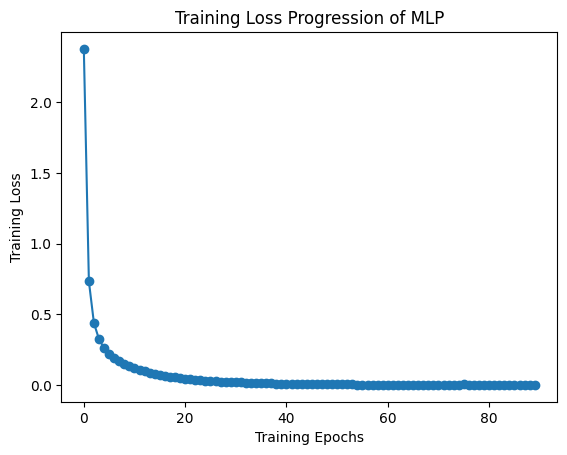

Best MLP Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}
MLP Train set Accuracy score: 1.00
MLP Test set Accuracy score: 0.96
Precision - Train set: 1.00
Precision - Test set: 0.97
Recall - Train set: 1.00
Recall - Test set: 0.96
F1-score - Train set: 1.00
F1-score - Test set: 0.96


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Combining the labels and preparing the dataset
df['combined_label'] = df['Currency'].astype(str) + '_' + df['Denomination'].astype(str)
df.drop(['Currency', 'Denomination'], axis=1, inplace=True)

# Label Encoding
le = LabelEncoder()
df['combined_label'] = le.fit_transform(df['combined_label'])
print("Different classes for the combined feature:", le.classes_)

# Splitting the dataset
X = df.drop('combined_label', axis=1)
y = df['combined_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM model training
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

clf = GridSearchCV(SVC(), parameters, cv=2, n_jobs=-1)
clf.fit(X_train, y_train)
print("Best SVM Parameters:", clf.best_params_)
train_pred_svm = clf.predict(X_train)
test_pred_svm = clf.predict(X_test)
print("SVM Train set Accuracy score: {:.2f}".format(accuracy_score(train_pred_svm, y_train)))
print("SVM Test set Accuracy score: {:.2f}".format(accuracy_score(test_pred_svm, y_test)))

# Standardizing features for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP model training
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'learning_rate_init': [0.01, 0.001]
}
mlp_grid_search = GridSearchCV(MLPClassifier(random_state=42), param_grid, cv=2, verbose=1, n_jobs=-1)
mlp_grid_search.fit(X_train_scaled, y_train)
best_mlp = mlp_grid_search.best_estimator_

# Plot loss curve
plt.plot(best_mlp.loss_curve_, marker='o')
plt.title('Training Loss Progression of MLP')
plt.xlabel('Training Epochs')
plt.ylabel('Training Loss')
plt.show()
print("Best MLP Parameters:", mlp_grid_search.best_params_)

# Evaluating MLP performance
train_pred_mlp = best_mlp.predict(X_train_scaled)
test_pred_mlp = best_mlp.predict(X_test_scaled)
print("MLP Train set Accuracy score: {:.2f}".format(accuracy_score(train_pred_mlp, y_train)))
print("MLP Test set Accuracy score: {:.2f}".format(accuracy_score(test_pred_mlp, y_test)))

# Calculate and display other metrics
metrics = {'Precision': precision_score, 'Recall': recall_score, 'F1-score': f1_score}
for name, metric_func in metrics.items():
    print(f"{name} - Train set: {metric_func(y_train, train_pred_mlp, average='weighted'):.2f}")
    print(f"{name} - Test set: {metric_func(y_test, test_pred_mlp, average='weighted'):.2f}")


**with pca**

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def apply_pca(X, n_components=100):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return pd.DataFrame(X_pca)

def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print(f"Train set Accuracy score: {accuracy_score(y_train, train_pred):.2f}")
    print(f"Test set Accuracy score: {accuracy_score(y_test, test_pred):.2f}")
    print("------------------------------------------------------------------")
    print("Test set Precision: {:.2f}".format(precision_score(y_test, test_pred, average='weighted')))
    print("Test set Recall: {:.2f}".format(recall_score(y_test, test_pred, average='weighted')))
    print("Test set F1-score: {:.2f}".format(f1_score(y_test, test_pred, average='weighted')))
    return train_pred, test_pred

df_PCA = apply_pca(X)

# Split the PCA-transformed dataset
X_train, X_test, y_train, y_test = train_test_split(df_PCA, y, test_size=0.2, random_state=42)

# SVM Classifier
svm_classifier = SVC(kernel='linear', C=1)
print("SVM Classifier Metrics:")
svm_train_pred, svm_test_pred = train_and_evaluate(svm_classifier, X_train, y_train, X_test, y_test)

# MLP Classifier
mlp_classifier = MLPClassifier(activation='tanh', hidden_layer_sizes=(80,), learning_rate_init=0.001, max_iter=1000, random_state=42)
print("MLP Classifier Metrics:")
mlp_train_pred, mlp_test_pred = train_and_evaluate(mlp_classifier, X_train, y_train, X_test, y_test)


SVM Classifier Metrics:
Train set Accuracy score: 1.00
Test set Accuracy score: 0.96
------------------------------------------------------------------
Test set Precision: 0.96
Test set Recall: 0.96
Test set F1-score: 0.96
MLP Classifier Metrics:
Train set Accuracy score: 1.00
Test set Accuracy score: 0.95
------------------------------------------------------------------
Test set Precision: 0.96
Test set Recall: 0.95
Test set F1-score: 0.95
